In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import ensemble
from sklearn import linear_model

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [2]:
df = zillow.LoadTabularData("data/")

In [3]:
zillow.LoadImageDataIntoDataFrame(df, "data/")

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


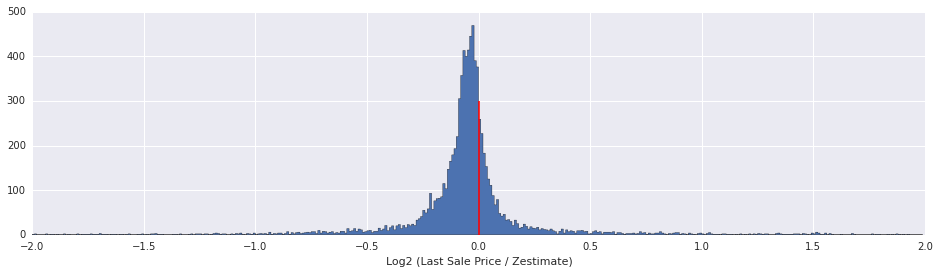

In [4]:
figsize(16, 4)
plt.hist(df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01), histtype="stepfilled")
plt.vlines(0, 0, 300, edgecolor="red", alpha=0.9)
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.show()

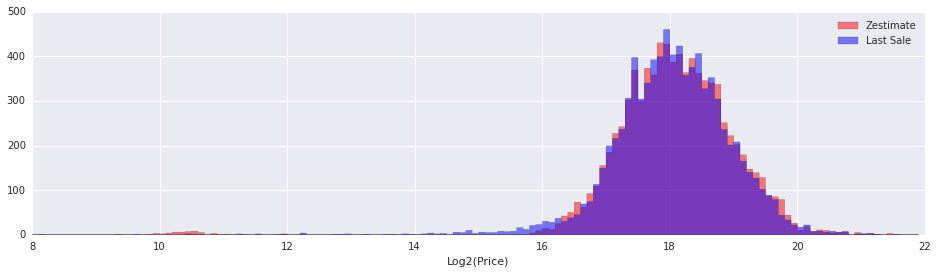

In [5]:
figsize(16, 4)
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.legend()
plt.show()

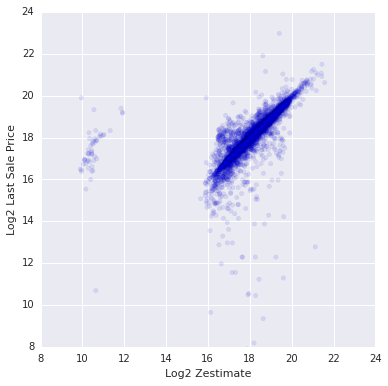

In [6]:
figsize(6, 6)
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.1)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.show()

# Prepare Data for Training

In [7]:
df["region"] = df.city + df.state + df.zip.astype(str)
region_encoder = dict((r, n) for n, r in enumerate(df.region.unique()))
df["region_code"] = df.region.map(lambda r: region_encoder[r])

In [8]:
ixs = np.arange(df.shape[0])
np.random.shuffle(ixs)
n_test = int(df.shape[0] / 10)
test_ixs = ixs[:n_test]
train_ixs = ixs[n_test:]
test_df = df.iloc[test_ixs]
train_df = df.iloc[train_ixs]

# Traditional ML & Statistical Models Trained on Home Facts

In [9]:
_, vf = zillow.VectorizeFacts(df.region.map(lambda r: [r]) + df.facts)
vf.shape

(8523, 443)

In [10]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_leaf_nodes=50, n_jobs=-1)
rfr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=50, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
rfr_preds = rfr.predict(vf[test_ixs])

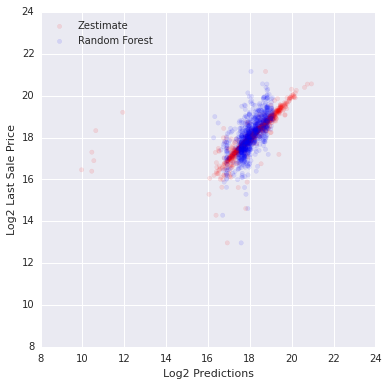

In [12]:
figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rfr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Random Forest", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

In [13]:
olsr = linear_model.LinearRegression(n_jobs=-1)
olsr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

/Library/Python/2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [14]:
olsr_preds = olsr.predict(vf[test_ixs])

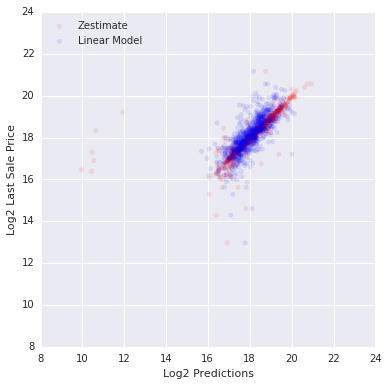

In [15]:
figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    olsr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Linear Model", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

In [16]:
print "zst", (np.log2(test_df.zestimate) - np.log2(test_df.last_sold)).abs().mean()
print "ols", (olsr_preds - np.log2(test_df.last_sold)).abs().mean()
print "rfr", (rfr_preds - np.log2(test_df.last_sold)).abs().mean()

zst 0.218183721161
ols 0.416716958083
rfr 0.497425931133


# Build a network in Keras to Learn from Images

In [17]:
from keras import models, layers, optimizers, backend

Using TensorFlow backend.


In [18]:
def ConvolutionalRegressor(n_regions):
    # Convolutional portion
    img_model = models.Sequential()

    img_model.add(layers.Conv2D(32, 5, 5, border_mode="same", input_shape=(128, 128, 3)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(48, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(96, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(128, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))
    
    img_model.add(layers.Conv2D(32, 4, 4, border_mode="valid"))
    img_model.add(layers.Reshape((32,)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    
    # Embedding portion for region
    embed_model = models.Sequential()
    embed_model.add(layers.embeddings.Embedding(n_regions, 16, input_length=1))
    embed_model.add(layers.Reshape((16,)))
    img_model.add(layers.Dropout(0.5))
    
    # Merge
    merged = layers.Merge([img_model, embed_model], mode="concat")
    merged_model = models.Sequential()
    merged_model.add(merged)
    merged_model.add(layers.Dense(10))
    merged_model.add(layers.BatchNormalization())
    merged_model.add(layers.LeakyReLU(0.2))
    merged_model.add(layers.Dense(1))

    return merged_model

In [19]:
cr = ConvolutionalRegressor(max(region_encoder.values()) + 1)

In [ ]:
cr.compile(optimizer="adam", loss="mse")

In [ ]:
cr_history = cr.fit(
    [np.array(train_df.image.tolist()), np.array(train_df.region_code)],
    np.array(np.log2(train_df.last_sold)),
    batch_size=16,
    nb_epoch=5,
    verbose=1,
    validation_data=(
        [np.array(test_df.image.tolist()), np.array(test_df.region_code)],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True)

Train on 7671 samples, validate on 852 samples
Epoch 1/5
 544/7671 [=>............................] - ETA: 958s - loss: 334.7602

In [ ]:
df["predictions"] = cr.predict(
    [np.array(df.image.tolist()), np.array(df.region_code)],
    verbose=1)

In [ ]:
test_df.loc[test_ixs, "predictions"] = df.iloc[test_ixs].predictions
target_df = test_df

figsize(6, 6)
plt.scatter(
    np.log2(target_df.zestimate), np.log2(target_df.last_sold),
    alpha=0.2, color="red", label="Zestimate")
plt.scatter(
    target_df.predictions, np.log2(target_df.last_sold),
    alpha=0.2, color="blue", label="Our Predictions")
plt.xlabel("Log2 Predicted Price")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend()
plt.show()